In [17]:
from openpiv import windef  # <---- see windef.py for details
from openpiv import tools, scaling, validation, filters, preprocess
import openpiv.pyprocess as process
from openpiv import pyprocess
import numpy as np
import pathlib
import importlib_resources
from time import time
import warnings
import cv2 as cv
from skimage import transform
from nd2reader import ND2Reader
from scipy.ndimage.filters import gaussian_filter, gaussian_filter1d
import sys
sys.path.append(r"D:\ESPCI\codes\multgridPIV")  # Add the folder containing the script to the Python path
import windef_modified  # Import the script as a module
import openpiv.filters
import h5py
import math
from matplotlib.patches import Circle
import matplotlib.patches as patches
from rich.console import Console
console = Console()

# Import the ScaleBar class
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.font_manager as fm

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Load the .nd2 file using ND2Reader
im1 = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2")

# Define the time points to analyze to see the image loaded
t1 = 60  # Time point 1
t2 = 61  # Time point 2

# Define the Gaussian filter parameters for background and noise correction
gauss_bg = 101  # Background Gaussian filter radius
gauss_ns = 1    # Noise Gaussian filter radius

# Extract images at the specified time points
im1_t0 = im1[t1]  # Image at time point t1
im2_t0 = im1[t2]  # Image at time point t2

# Correct for background and noise using Gaussian filters
im1_t0_fil = gaussian_filter(im1_t0 / gaussian_filter(im1_t0, gauss_bg), gauss_ns)
im2_t0_fil = gaussian_filter(im2_t0 / gaussian_filter(im2_t0, gauss_bg), gauss_ns)

# Import the PIVSettings class from the windef module
settings = windef_modified.PIVSettings()


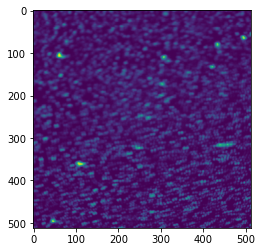

In [19]:
%matplotlib inline
plt.imshow(im1_t0_fil)

In [4]:
dt = (im1.timesteps[t2] - im1.timesteps[t1]) * 1e-3 # The timestep of the conofocal time stack

In [5]:
dt

1.4502129230499268

### The below parameters are trialed over different value and I keep them fix over my calculations

In [21]:
'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS
###settings.dynamic_masking_method = 'None'
###settings.dynamic_masking_threshold = 0.005
###settings.dynamic_masking_filter_size = 7
###'Region of interest'  (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image 
settings.roi = 'full'#(0,512,50,450)###
settings.dynamic_masking_method = 'None'
settings.dynamic_masking_threshold = 0.005
settings.dynamic_masking_filter_size = 7

settings.deformation_method = 'symmetric'

'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation=False

settings.num_iterations = 3 #2 # select the number of PIV passes
# add the interroagtion window size for each pass.
# For the moment, it should be a power of 2
settings.windowsizes = ([128,64,32])#([64,32]) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
settings.overlap = ([32,16,8])#([16,8]) # This is 50% overlap
# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'
# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = (im1.timesteps[t2] - im1.timesteps[t1]) * 1e-3  # time between two frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN
'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True
# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated
'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.min_max_u_disp = (-30, 30)
settings.min_max_v_disp = (-30, 30)
# The second filter is based on the global STD threshold
###settings.std_threshold = 7  # threshold of the std validation
# The third filter is the median test (not normalized at the moment)
###settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
##settings.median_size=1 #defines the size of the local median
'Validation based on the signal to noise ratio'
# Note: only available when extract_sig2noise==True and only for the last
# pass of the interrogation
# Enable the signal to noise ratio validation. Options: True or False
# settings.do_sig2noise_validation = False # This is time consuming
# minmum signal to noise ratio that is need for a valid vector
settings.sig2noise_threshold = 1.05 #1.08
'Outlier replacement or Smoothing options'
# Replacment options for vectors which are masked as invalid by the validation
settings.replace_vectors = True # Enable the replacment. Chosse: True or False
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter
# select a method to replace the outliers: 'localmean', 'disk', 'distance'
settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4 #4
settings.filter_kernel_size = 1  # 1; kernel size for the localmean method
##'Output options'
# Select if you want to save the plotted vectorfield: True or False
##settings.save_plot = True
# Choose wether you want to see the vectorfield or not :True or False
##settings.show_plot = True
##settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings

### Here in the module of piv and deformation field

In [22]:
%matplotlib auto
### Commented code

import time

# Start measuring execution time
start = time.time()

# Parameters
ti = 0  # First frame index
tf = 110  # Last frame index
filter_size = 0  # Filter size
gauss_bg = 101  # Background Gaussian filter size
gauss_ns = 1  # Noise suppression Gaussian filter size

im = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2") # Read ND2 file
px = np.array([im.metadata['pixel_microns']*1e-06, im.metadata['pixel_microns']*1e-06])  # Pixel size
im1_t0 = im[ti]  # Get first image
#im_folder = "D:\ESPCI\Experiments\mechanoconfocal\20231220\sample_1mm\sample_1_stodv1_imperfect_dogbone\analysis\images\quivers" #Image folder path

x0,y0  = pyprocess.get_coordinates(im1_t0.shape,search_area_size=settings.windowsizes[-1], overlap=settings.overlap[-1])

# Initialize an array to store intensity values
intensity_array = np.zeros((x0.shape[0], x0.shape[1]))
intensity_threshold = 0.5

args = {
    'time_resolution': settings.dt,
    'window_size': settings.windowsizes,
    'overlap_size': settings.overlap,
    'first_frame': ti,
    'last_frame': tf,
    
}
#'image_file': im_folder

##h5py_file = r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5"

# Create or open the HDF5 file
with h5py.File(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol8.h5", "a") as h5file:
    # Prepare the output arrays on disk
    flow = h5file.require_dataset(
        "FlowField",
        (tf - ti, x0.shape[0], x0.shape[1], 2),
        dtype='float32'
    )
    grad_field = h5file.require_dataset(
        "gradient_field",
        (tf - ti, x0.shape[0], x0.shape[1], 2, 2),
        dtype='float32'
    )

    # Save all analysis parameters
    for k, v in args.items():
        flow.attrs[k] = v

    for i in range(ti, tf):
        im1 = im[i]  # Get current image
        im2 = im[i + 1]  # Get next image

        # Apply filters to images
        im1_fil = gaussian_filter(im1 / gaussian_filter(im1, gauss_bg), gauss_ns)
        im2_fil = gaussian_filter(im2 / gaussian_filter(im2, gauss_bg), gauss_ns)

        dt = (im.timesteps[i + 1] - im.timesteps[i]) * 1e-3  # Time difference between frames

        # Perform PIV analysis
        x, y, u, v, flags = windef_modified.simple_multipass(im1_fil,im2_fil,settings)
        y = y[::-1,:]
        u /= settings.dt
        v /= settings.dt
        v = -v

        # Reinitialize an array to store intensity values
        intensity_array = np.zeros((x0.shape[0], x0.shape[1]))
        # Store velocities in the HDF5 file
        for j in range(flow[i - ti].shape[0]):
            for k in range(flow[i - ti].shape[1]):
 
                flow[i - ti, j, k] = u[j, k] * px[0], v[j, k] * px[1]

           # Calculate the average intensity within the window
                intensity_array[j, k] = np.mean(im1_fil[int(y[j,k]-settings.windowsizes[-1]//2) : int(y[j,k]+settings.windowsizes[-1] // 2),
                                                          int(x[j,k]-settings.windowsizes[-1]//2) : int(x[j,k]+settings.windowsizes[-1] // 2)])
                

                

        # Calculate gradient field
        grad = np.gradient(flow[i - ti], axis=(0, 1),  *(px * np.array([settings.windowsizes[-1] - settings.overlap[-1],
                                                                        settings.windowsizes[-1] - settings.overlap[-1]])))
        gd_maar = np.zeros((x0.shape[0], x0.shape[1], 2, 2))
        for j in range(2):
            for k in range(2):
                gd_maar[..., j, k] = grad[j][..., k]

## Change the flag to intensity based 
        flags =  intensity_array>intensity_threshold
        
        
        gd_maar = np.roll(gd_maar, shift=1, axis=2)
        #gd_maar[~flags] = 0
        
        
        grad_field[i - ti] = gd_maar

        

        # Apply flags to eliminate wrong quiver values
        uplot = u
        vplot = v
        uplot[~flags] = np.nan
        vplot[~flags] = np.nan
        
        # Plot and save the result
        fig, axs = plt.subplots(1, 1, figsize=(16, 12), constrained_layout=True)
        axs.imshow(im2)
        fig.gca().invert_yaxis()
        axs.quiver(x, y, u, v, color='white', scale = 0.05, scale_units='xy')
        # Add a scalebar to the lower right corner
        ##font_properties = fm.FontProperties(size=18)
        scalebar = ScaleBar(px[0], location='lower right', length_fraction=0.25)
        axs.add_artist(scalebar)
        #plt.savefig(
        #    r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_2\scotch_3\test_1\analysis\images\quivers\win_128_64_32_ol_32_16_8\t_{:04d}".
        #    format(i))
        plt.close()
        fig1, axs1 = plt.subplots(1, 1, figsize=(16, 12), constrained_layout=True)
        axs1.imshow(flags)

        print('\r%d (%.01f %%)' % (i, 100 * (i - ti) / flow.shape[0]), sep=' ', end=' ', flush=True)
        plt.close()
    print("\ndone!")

# End measuring execution time
end = time.time()
print(end - start)


Using matplotlib backend: Qt5Agg
109 (99.1 %) 
done!
107.42842626571655


## Post Analysis:This is to be carried out after running the above module. 
- Plot the displacement and strain field field in between  particular time frame
- calculate global tensile and contractile strain across the image

Text(0.5, 1.0, 'Average Intensity Map')

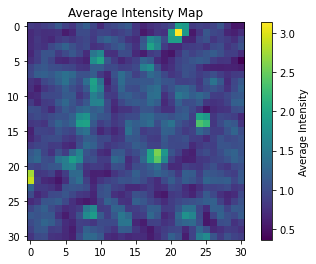

In [8]:
%matplotlib inline
# Visualize the intensity_array with a color bar
plt.imshow(intensity_array, cmap='viridis')  # You can choose any colormap you prefer
plt.colorbar(label='Average Intensity')  # Add a color bar with a label
plt.title('Average Intensity Map')

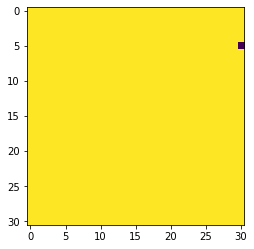

In [9]:
plt.imshow(flags)

### Plot the quiver, strain field, magnitude between two frames

[128  64  32]
[32 16 16]
the maximum and minim of u from ESA_PIV are 1.0639397260092665e-05 and 1.048932176672679e-06
the maximum and minim of v from ESA_PIV are 6.021470198902534e-06 and -1.0987280347762862e-06


maximum and minimum of gradient rate $\dot{\frac{du}{dx}}$ is [0.051377136, -0.04644742]

the magnitude of gradient $\dot{\frac{du}{dx}}$ is 0.004968990571796894

0.051377136


maximum and minimum of strain rate $\epsilon_{xx}$ is [0.051377136, -0.025356462]

the magnitude of strain rate $\epsilon_{xx}$ is 0.004968990571796894

maximum and minimum of strain rate $\epsilon_{yx}$ is [0.020544538, -0.012134408]

the magnitude of strain rate $\epsilon_{yx}$ is 0.0017114891670644283

maximum and minimum of strain rate $\epsilon_{xy}$ is [0.020544538, -0.012134408]

the magnitude of strain rate $\epsilon_{xy}$ is 0.0017114891670644283

maximum and minimum of strain rate $\epsilon_{yy}$ is [0.021987481, -0.04644742]

the magnitude of strain rate $\epsilon_{yy}$ is 0.002748191123828292

The average norm of the strain rate is 0.0069852652959525585

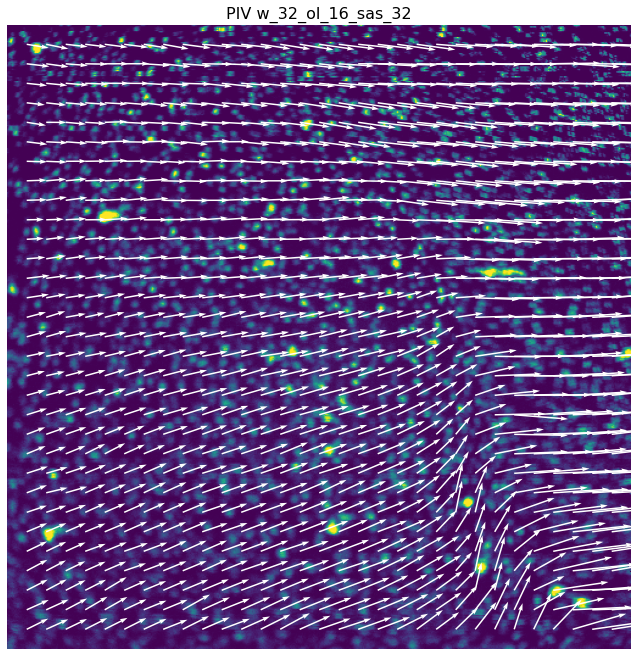

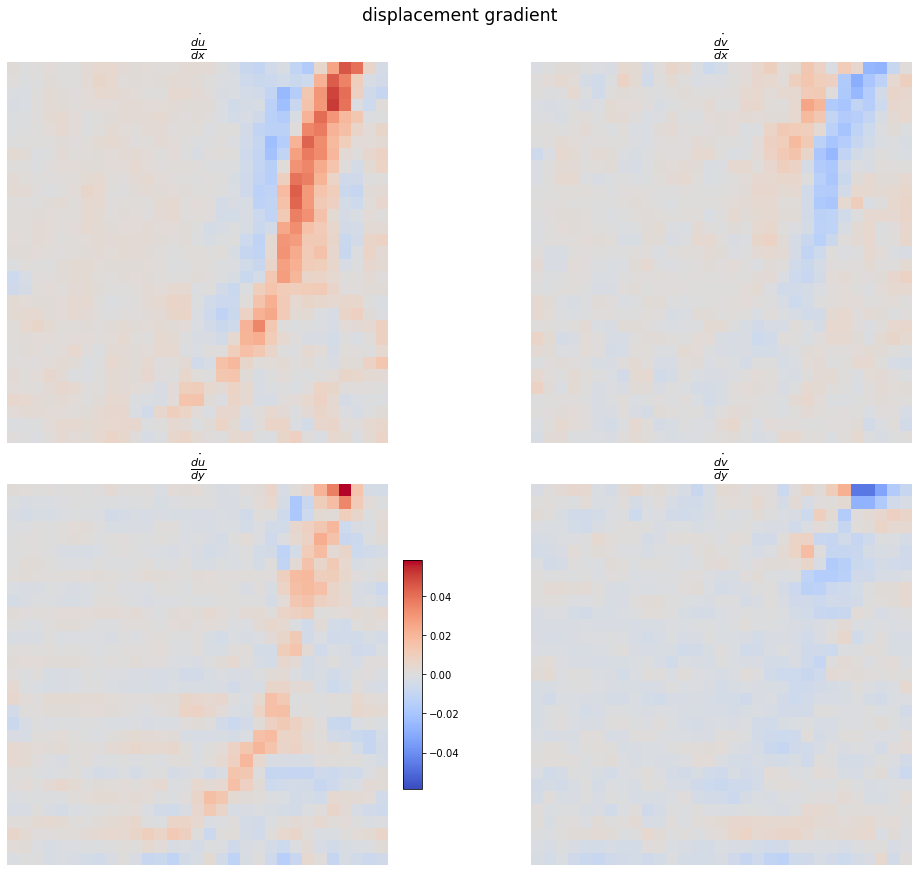

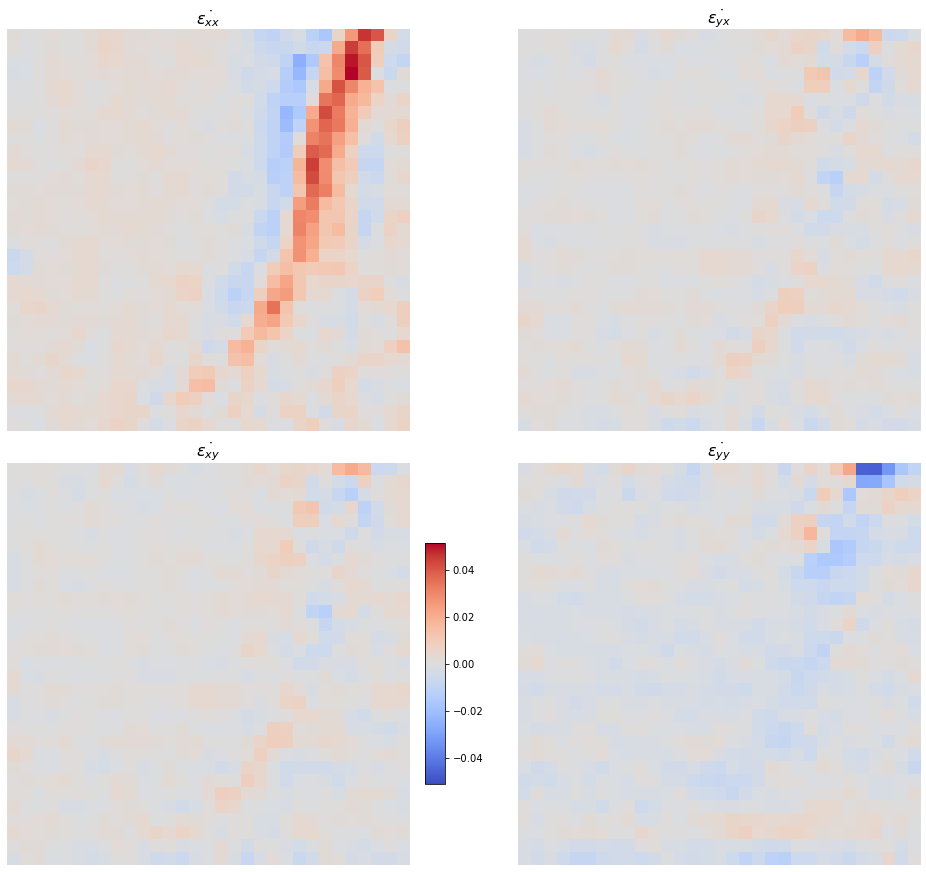

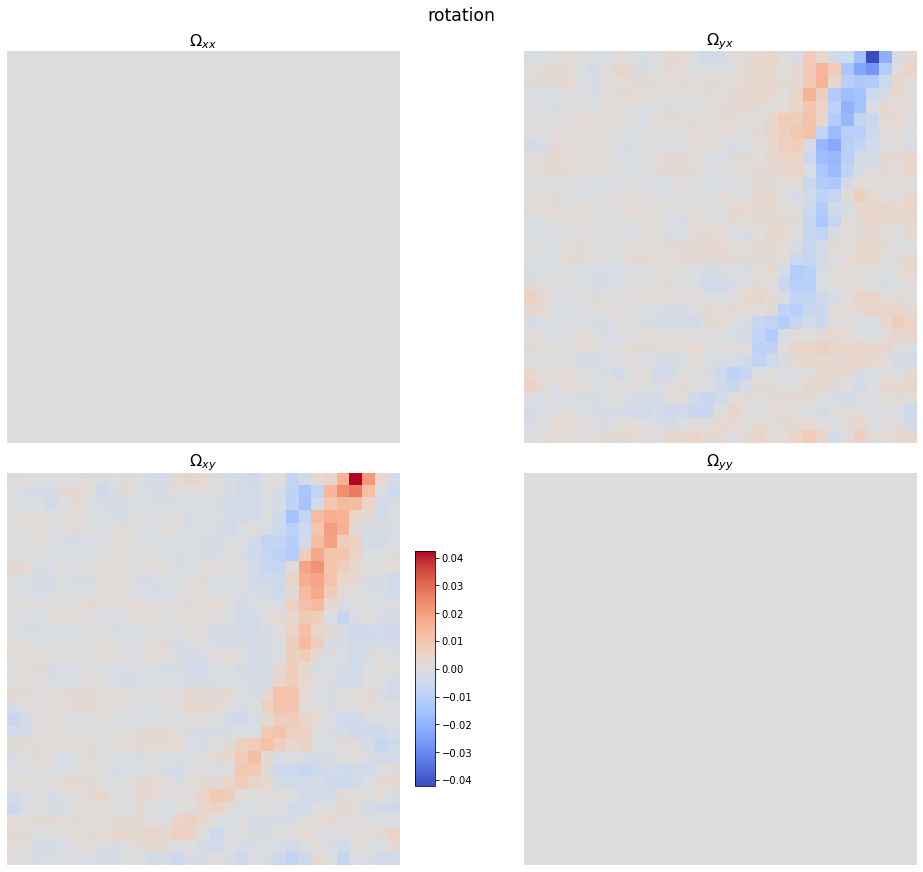

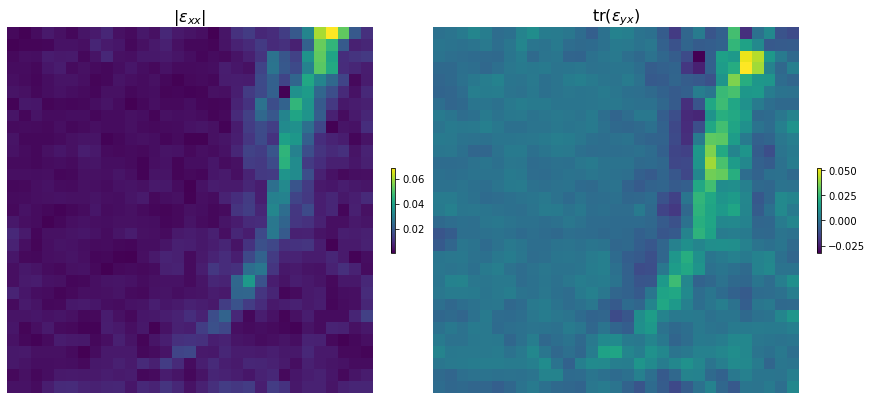

In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

im = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2") # Read ND2 file

# Set the pixel size
px = np.array([im.metadata['pixel_microns']*1e-06, im.metadata['pixel_microns']*1e-06])  # Pixel size

# Set the time indices
t1 = 40
t2 = 41

# Read the ND2 file
#im_folder = "D:\ESPCI\Experiments\mechanoconfocal\20231220\sample_1mm\sample_1_stodv1_imperfect_dogbone\analysis\images\quivers"  #Image folder path

# Read the images at time indices t1 and t2
im1 = im[t1]
im2 = im[t2]

# Calculate the time difference
dt = (im.timesteps[t2] - im.timesteps[t1]) * 1e-3

# Open the HDF5 file
with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5', 'r') as h5file:
    ls = list(h5file.keys())
    data = h5file.get('FlowField')
    atts = dict(data.attrs)
    print(atts['window_size'])
    print(atts['overlap_size'])
    ws = atts['window_size'][-1]
    os = atts['overlap_size'][-1]
    
    # Read the gradient field and flow field arrays at time index t1
    grad_array = h5file.get('gradient_field')[t1]
    flowfield_array = h5file.get('FlowField')[t1]
    
    print ('the maximum and minim of u from ESA_PIV are {} and {}'.format(flowfield_array[:,:,0].max(),flowfield_array[:,:,0].min())) 
    print ('the maximum and minim of v from ESA_PIV are {} and {}'.format(flowfield_array[:,:,1].max(),flowfield_array[:,:,1].min())) 
    # Calculate strain field and rotation field
    strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
    rotation = 0.5 * (grad_array - grad_array.transpose(0, 1, 3, 2))
    
    # Plot image and flow field
    fig, axs = plt.subplots(1, 1, figsize=(12, 9), sharey='row', constrained_layout=True)
    axs.imshow(im2,extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]), origin = 'lower')
    x = np.arange(0, flowfield_array.shape[1])
    y = np.arange(0, flowfield_array.shape[0])
    u = flowfield_array[..., 0]
    v = flowfield_array[..., 1]
    X, Y = np.meshgrid(x, y)
    axs.quiver((ws / 2 + x * (ws - os)) * px[0], (ws / 2 + y * (ws - os)) * px[0], u, v, color='white',
               scale=0.5 * 1e-1, scale_units='xy')
    axs.set_title('PIV w_{}_ol_{}_sas_{}'.format(ws, os, ws), fontsize=16)
    axs.axis('off')
    
    # Plot displacement gradient
    fig, axs = plt.subplots(grad_array.shape[-2], grad_array.shape[-1], figsize=(13, 12), constrained_layout=True)
    fig.suptitle('displacement gradient', size='xx-large')
    subplot_titles = [r'$\dot{\frac{du}{dx}}$', r'$\dot{\frac{dv}{dx}}$', r'$\dot{\frac{du}{dy}}$', r'$\dot{\frac{dv}{dy}}$']
    vv = np.abs(grad_array).max()
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            im_grad = ax.imshow(grad_array[..., i, j], 'coolwarm', vmin=-vv, vmax=vv, 
                                extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]))
    for nax, ax in enumerate(axs.flatten()):
        ax.set_title(subplot_titles[nax], fontsize=16)
        ax.axis('off')
    cax = axs[1, 1].inset_axes([1.04, 0.2, 0.05, 0.6], transform=axs[1, 0].transAxes)
    fig.colorbar(im_grad, ax=axs[0, 0], cax=cax, shrink=0.5)
    console.print(f"maximum and minimum of gradient rate {subplot_titles[0]} is {[grad_array[..., 0, 0].max(), grad_array[..., 1, 1].min()]}", style="bold cyan")
    console.print(f"the magnitude of gradient {subplot_titles[0]} is {np.abs(grad_array[..., 0, 0]).mean()}", style="bold yellow")
    
    # Plot strain field
    fig, axs = plt.subplots(grad_array.shape[-2], grad_array.shape[-1], figsize=(13, 12), constrained_layout=True)
    #fig.suptitle('strain', size='xx-large')
    subplot_titles = [r'$\dot{\epsilon_{xx}}$', r'$\dot{\epsilon_{yx}}$', r'$\dot{\epsilon_{xy}}$', r'$\dot{\epsilon_{yy}}$']
    subplot_titles_2 = np.array([[r'$\epsilon_{xx}$', r'$\epsilon_{yx}$'],
                                 [r'$\epsilon_{xy}$', r'$\epsilon_{yy}$']])
    vv = np.abs(strain_field).max()
    print(vv)
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            im_grad = ax.imshow(strain_field[..., i, j], 'coolwarm', vmin=-vv, vmax=vv, 
                                extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]))
            console.print(f"maximum and minimum of strain rate {subplot_titles_2[i, j]} is {[strain_field[..., i, j].max(), strain_field[..., i, j].min()]}", style="bold cyan")
            console.print(f"the magnitude of strain rate {subplot_titles_2[i, j]} is {np.abs(strain_field[..., i, j]).mean()}", style="bold yellow")
    for nax, ax in enumerate(axs.flatten()):
        ax.set_title(subplot_titles[nax], fontsize=16)
        ax.axis('off')
    cax = axs[1, 1].inset_axes([1.04, 0.2, 0.05, 0.6], transform=axs[1, 0].transAxes)
    fig.colorbar(im_grad, ax=axs[0, 0], cax=cax, shrink=0.5)
    #plt.savefig(r"D:\ESPCI\seminar\Presentation\Meet_20230719\strainfield_t{}".format(t1))
    
    # Plot rotation field
    fig, axs = plt.subplots(grad_array.shape[-2], grad_array.shape[-1], figsize=(13, 12), constrained_layout=True)
    fig.suptitle('rotation', size='xx-large')
    subplot_titles = [r'$\Omega_{xx}$', r'$\Omega_{yx}$', r'$\Omega_{xy}$', r'$\Omega_{yy}$']
    vv = np.abs(rotation).max()
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            im_grad = ax.imshow(rotation[..., i, j], 'coolwarm', vmin=-vv, vmax=vv,
                                 extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]))
    for nax, ax in enumerate(axs.flatten()):
        ax.set_title(subplot_titles[nax], fontsize=16)
        ax.axis('off')
    cax = axs[1, 1].inset_axes([1.04, 0.2, 0.05, 0.6], transform=axs[1, 0].transAxes)
    fig.colorbar(im_grad, ax=axs[0, 0], cax=cax, shrink=0.5)
    
    # Plot norm and trace of strain fields
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    subplot_titles = [r'|$\epsilon_{xx}|$', r'tr($\epsilon_{yx}$)']
    norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))
    im1 = axs[0].imshow(norm_strain, extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]))
    trace_strain = np.trace(strain_field, axis1=-2, axis2=-1)
    im2 = axs[1].imshow(trace_strain, extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]))
    implt = [im1, im2]
    for nax, ax in enumerate(axs.flatten()):
        ax.set_title(subplot_titles[nax], fontsize=16)
        fig.colorbar(implt[nax], ax=ax, shrink=0.2)
        ax.axis('off')
    console.print('The average norm of the strain rate is {}'.format(norm_strain.mean()))

    #plt.savefig('D:\ESPCI\seminar\Presentation\Meet_14_Oct_2022/norm_trace_field_t_{}.png'.format(t1))

### Save the image of the tensorial stain rate field and its norm and trace

In [12]:
%matplotlib auto

im = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2") # Read ND2 file

# Set the pixel size
px = np.array([im.metadata['pixel_microns']*1e-06, im.metadata['pixel_microns']*1e-06])  # Pixel size

# Set the time indices
ti = 0
tf = 110


# Read the images at time indices t1 and t2
im1 = im[ti]
im2 = im[tf]
# Read the ND2 file
im_folder = "D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\analysis\images\quivers" #Image folder path

vvmax_global_mag = 0.1
vvmax_global_trace = 0.1
# Calculate the time difference
dt = (im.timesteps[t2] - im.timesteps[t1]) * 1e-3

for t in range(ti,tf):
    # Open the HDF5 file
    with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol8.h5', 'r') as h5file:
        ls = list(h5file.keys())
        data = h5file.get('FlowField')
        atts = dict(data.attrs)
        ws = atts['window_size'][-1]
        os = atts['overlap_size'][-1]

        # Read the gradient field and flow field arrays at time index t1
        grad_array = h5file.get('gradient_field')[t]
        flowfield_array = h5file.get('FlowField')[t]

        # Calculate strain field and rotation field
        strain_rate_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
        
        
        # Plot strain field
        fig, axs = plt.subplots(grad_array.shape[-2], grad_array.shape[-1], figsize=(13, 12), constrained_layout=True)
        #fig.suptitle('strain', size='xx-large')
        subplot_titles = [r'$\dot{\epsilon_{xx}}$', r'$\dot{\epsilon_{yx}}$', r'$\dot{\epsilon_{xy}}$', r'$\dot{\epsilon_{yy}}$']
        subplot_titles_2 = np.array([[r'$\epsilon_{xx}$', r'$\epsilon_{yx}$'],
                                     [r'$\epsilon_{xy}$', r'$\epsilon_{yy}$']])
        vv = np.abs(strain_field).max()
        for i, row in enumerate(axs):
            for j, ax in enumerate(row):
                im_grad = ax.imshow(strain_rate_field[..., i, j], 'coolwarm', vmin=-vv, vmax=vv, 
                                    extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]))
        for nax, ax in enumerate(axs.flatten()):
            ax.set_title(subplot_titles[nax], fontsize=16)
            ax.axis('off')
        cax = axs[1, 1].inset_axes([1.04, 0.2, 0.05, 0.6], transform=axs[1, 0].transAxes)
        fig.colorbar(im_grad, ax=axs[0, 0], cax=cax, shrink=0.5)
        plt.savefig(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\analysis\images\strain_field\win_128_64_32_ol_32_16_16\tensorial\t_{:04d}.png".format(t))
        plt.close()
        
        
        # Plot norm and trace of strain fields
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        subplot_titles = [r'|$\dot{\epsilon_{xx}}|$', r'tr($\dot{\epsilon_{yx}}$)']
        norm_strain_rate = np.linalg.norm(strain_rate_field, axis=(-2, -1))
        vv =0.05
        im11 = axs[0].imshow(norm_strain_rate, extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]), vmin=-vv, vmax=vv)
        
        trace_strain_rate = np.trace(strain_rate_field, axis1=-2, axis2=-1)
        vv2 = 0.05
        im22 = axs[1].imshow(trace_strain_rate, extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]), vmin=-vv, vmax=vv)
        implt = [im11, im22]
        for nax, ax in enumerate(axs.flatten()):
            ax.set_title(subplot_titles[nax], fontsize=16)
            fig.colorbar(implt[nax], ax=ax, shrink=0.2)
            ax.axis('off')
        #console.print('The average norm of the strain rate is {}'.format(norm_strain.mean()))
        plt.savefig(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\analysis\images\strain_field\\win_128_64_32_ol_32_16_16\mag\t_{:04d}.png".format(t))
        plt.close()

Using matplotlib backend: Qt5Agg


### This is the plotting and saving cumulative strain field from ti to t in image format

In [16]:
%matplotlib auto

im = ND2Reader(r"sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2") # Read ND2 file

# Set the pixel size
px = np.array([im.metadata['pixel_microns']*1e-06, im.metadata['pixel_microns']*1e-06])  # Pixel size

# Set the time indices
ti = 13 #see global strain below. The intersity are changing so I ignore the intial 10 frames
tf = 110 #12 less again to avoid the issue of bad correlation


# Read the images at time indices t1 and t2
im1 = im[ti]
im2 = im[tf]
# Read the ND2 file
im_folder = "D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\analysis\images\quivers" #Image folder path

vvmax_global_mag = 0.1
vvmax_global_trace = 0.1
# Calculate the time difference
dt = (im.timesteps[t2] - im.timesteps[t1]) * 1e-3

for t in range(ti,tf):
    # Open the HDF5 file
    with h5py.File('20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5', 'r') as h5file:
        ls = list(h5file.keys())
        data = h5file.get('FlowField')
        atts = dict(data.attrs)
        ws = atts['window_size'][-1]
        os = atts['overlap_size'][-1]

        # Read the gradient field and flow field arrays at time index t1
        grad_array = h5file.get('gradient_field')[ti:t].sum(axis = 0)*dt ###cumulatively adding all the frame from ti to t 
        #flowfield_array = h5file.get('FlowField')[t]

        # Calculate strain field and rotation field
        strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
        
        
        
        # Plot norm and trace of strain fields
        fig, axs = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
        subplot_titles = [r'|$\epsilon_{xx}|$', r'tr($\epsilon_{yx}$)']
        norm_strain = np.linalg.norm(strain_field, axis=(-2, -1))
        vv =0.3
        im11 = axs.imshow(norm_strain, extent=(0, im2.shape[1] * px[0], 0, im2.shape[0] * px[1]), vmin=0, vmax=vv)
        # Add text annotation
        axs.text(0.05, 0.95, 't = {:.2f} s'.format(t*dt), fontsize=16, color='white', ha='left', va='top', transform=axs.transAxes)
        axs.set_title(r'|$\epsilon_{xx}|$', fontsize=16)
        fig.colorbar(im11, ax=axs, shrink=0.5)  # Include mappable parameter and ax
        axs.axis('off')
        #console.print('The average norm of the strain rate is {}'.format(norm_strain.mean()))
        plt.savefig(r"D:\ESPCI\Experiments\mechanoconfocal\20240515\RTV615\box_1\scotch_3\test_1\analysis\images\strain_field\win_128_64_32_ol_32_16_16\strain_mag\t_{:04d}.png".format(t))
        plt.close()

Using matplotlib backend: Qt5Agg


[128  64  32]
[32 16 16]


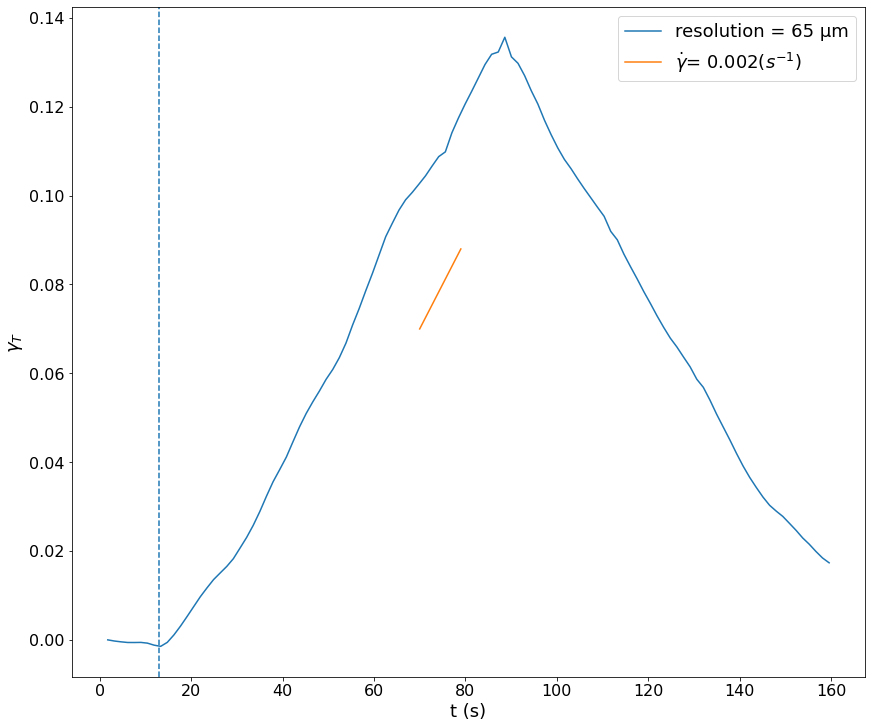

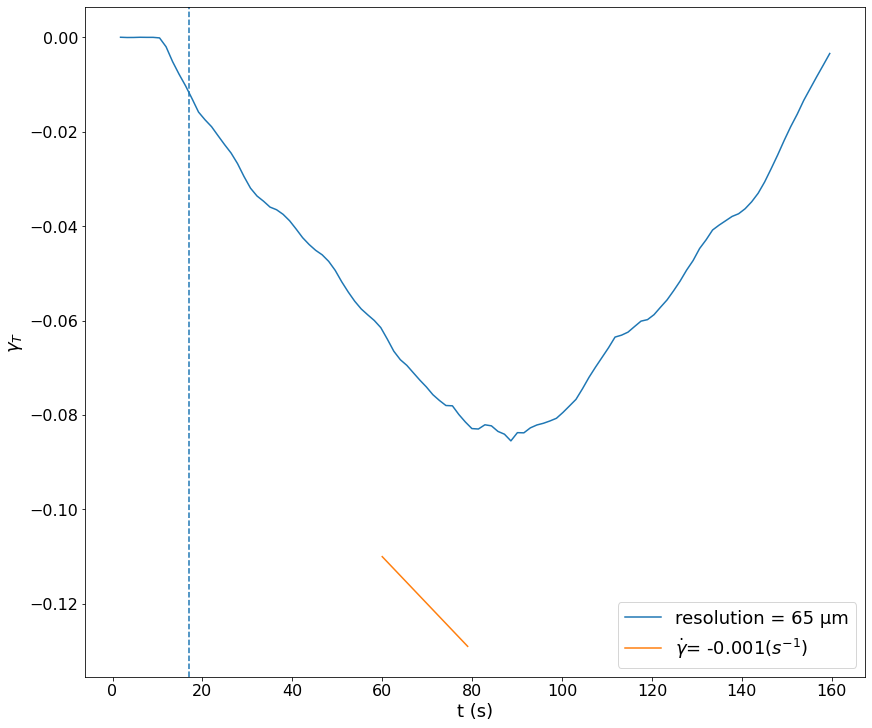

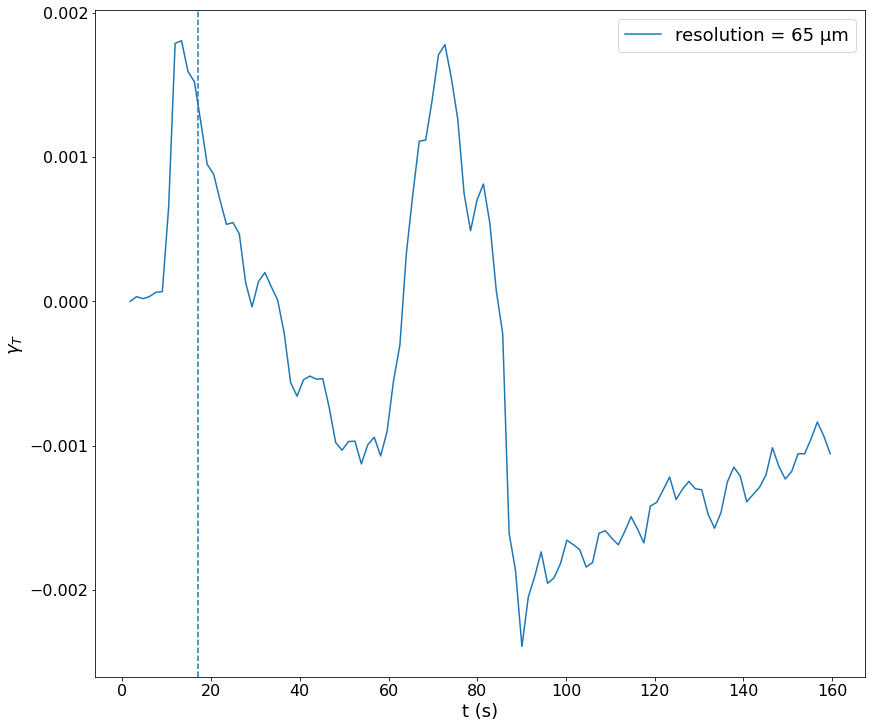

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

# Read ND2 file
im = ND2Reader("sample_rtv_20240514_box1_stodv1_scotch3_test_1.nd2") # Read ND2 file
# List of HDF5 file names
h5files = ['20240515_tensile0.005_RTV_box1_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5']

#'20240515_tensile0.005_RTV_1mm_scotch_3_test_1_multiscale3_w32_ol16_filker_2.h5','20240515_tensile0.005_RTV_1mm_scotch_3_test_1_multiscale3_w32_ol16.h5',
ti = 0  # First frame index
tf = 110  # Last frame index
# Set the pixel size
px = np.array([im.metadata['pixel_microns']*1e-06, im.metadata['pixel_microns']*1e-06])  # Pixel size

# Arrays to store strain values
tensile_strain_mean = np.zeros((len(h5files), tf - ti))
contraction_strain_mean = np.zeros((len(h5files), tf - ti))
shear_strain_mean = np.zeros((len(h5files), tf - ti))

# Time array
time = im.timesteps[ti:tf] * 1e-3

# Create figures and axes
fig, axs = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)
fig2, axs2 = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)
fig3, axs3 = plt.subplots(1, 1, figsize=(12, 10), constrained_layout=True)

# Iterate over HDF5 files
for (i, file) in enumerate(h5files):
    with h5py.File(file, 'r') as h5file:
        data = h5file.get('FlowField')
        atts = dict(data.attrs)
        ws = atts['window_size']
        os = atts['overlap_size']
        print(ws)
        print(os)

        # Calculate strain values for each frame
        for j in range(ti, tf):
            dt = (im.timesteps[j + 1] - im.timesteps[j]) * 1e-3
            grad_array = h5file.get('gradient_field')[:j].sum(axis=0) * dt
            strain_field = 0.5 * (grad_array + grad_array.transpose(0, 1, 3, 2))
            tensile_strain_mean[i, j] = (strain_field[..., 0, 0]).mean()
            contraction_strain_mean[i, j] = (strain_field[..., 1, 1]).mean()
            shear_strain_mean[i,j] = (strain_field[...,0,1]).mean()

    # Plot tensile strain
    slope = 0.002
    axs.plot(time, tensile_strain_mean[i], label='resolution = {} μm'.format(round((ws[-1] - os[-1]) * px[0] * 1e6)))
    if i ==0:
        axs.plot(np.arange(70,80),slope*np.arange(70,80)-0.07, label ='$\dot{\gamma}$'+ '= {}'.format(slope) + '$(s^{-1})$')
    axs.axvline(13, linestyle = '--')
    axs.legend(fontsize=18)
    axs.set_ylabel('$\gamma_{T}$', fontsize=18)
    axs.set_xlabel('t (s)', fontsize=18)
    axs.tick_params(axis="x", labelsize=16)
    axs.tick_params(axis="y", labelsize=16)

    # Plot contraction strain
    slope = -0.0010
    axs2.plot(time, contraction_strain_mean[i], label='resolution = {} μm'.format(round((ws[-1] - os[-1]) * px[0] * 1e6)))
    if i ==0:
        axs2.plot(np.arange(60,80),slope*np.arange(60,80)-0.05, label ='$\dot{\gamma}$'+ '= {}'.format(slope) + '$(s^{-1})$')
    axs2.axvline(17, linestyle = '--')
    axs2.legend(fontsize=18)
    axs2.set_ylabel('$\gamma_{T}$', fontsize=18)
    axs2.set_xlabel('t (s)', fontsize=18)
    axs2.tick_params(axis="x", labelsize=16)
    axs2.tick_params(axis="y", labelsize=16)
    
    # Plot shear strain
    slope = -0.00010
    axs3.plot(time, shear_strain_mean[i], label='resolution = {} μm'.format(round((ws[-1] - os[-1]) * px[0] * 1e6)))
#    if i ==0:
#        axs3.plot(np.arange(60,80),slope*np.arange(60,80)+0.005, label ='$\dot{\gamma}$'+ '= {}'.format(slope) + '$(s^{-1})$')
    axs3.axvline(17, linestyle = '--')
    axs3.legend(fontsize=18)
    axs3.set_ylabel('$\gamma_{T}$', fontsize=18)
    axs3.set_xlabel('t (s)', fontsize=18)
    axs3.tick_params(axis="x", labelsize=16)
    axs3.tick_params(axis="y", labelsize=16)


# Save figures
#fig.savefig('20240515_rtv_box2_stodv1_3scotch_ten0.005_avg_tension_multigrid.png')
#fig2.savefig('20240515_rtv_box2_stodv1_3scotch_ten0.005_avg_contract_multigrid.png')
#fig3.savefig('20240515_rtv_box2_stodv1_3scotch_ten0.005_avg_shear_multigrid.png')


## Finish